<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we are to implement the classification algorithms in the available dataset.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-31 14:31:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-08-31 14:31:07 (302 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    seaborn-0.10.1             |             py_0         160 KB  anaconda
    ca-certificates-2020.7.22  |                0         132 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.2 MB

The following packages will be UPDATED:

    ca-certificates: 2020.6.24-0        --> 2020.7.22-0       anaconda
    certifi:         2020.6.20-py36_0   --> 2020.6.20-py36_0  anaconda
    openssl:         1.1.1g-h7b6447c_0  --> 1.1.1g-h7b6447c_0 anaconda
    seaborn:         0.9.0-pyh91

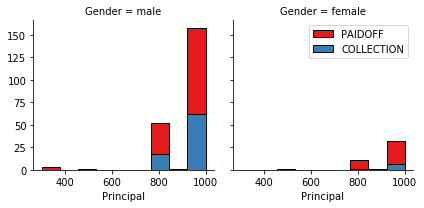

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

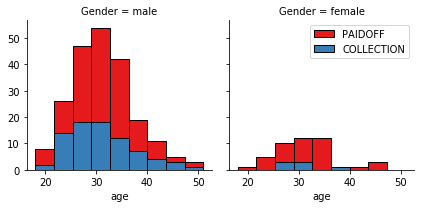

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

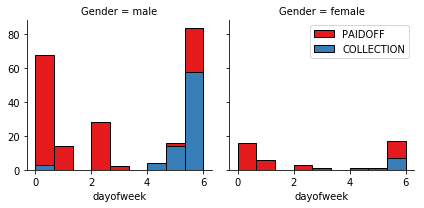

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot 

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [21]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-31 14:39:24--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-08-31 14:39:25 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [22]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing

In [23]:
df=pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [24]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

In [25]:
import random

In [26]:
education = random.choices(["High School or Below", "Bechalor", "college", "Master or Above"], k = 346)
Gender=random.choices(["male", "female"], k=346)

In [27]:
df["education"] = df["education"].map({"High School or Below":3, "Bechalor":4, "college":5, "Master or Above":6})

In [28]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,3,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,4,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,5,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,5,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,5,male


In [29]:
df["Gender"] = df["Gender"].map({"male":0, "female":1})

In [30]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,3,0
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,4,1
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,5,0
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,5,1
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,5,0


## Visualising the data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06e0f77e80>]],
      dtype=object)

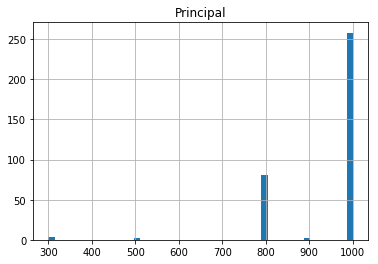

In [31]:
df.hist(column='Principal', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06e0c6b390>]],
      dtype=object)

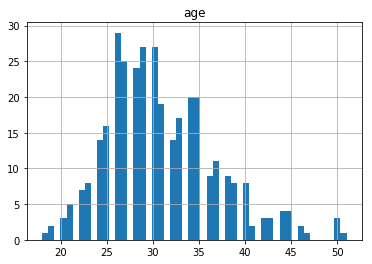

In [32]:
df.hist(column='age', bins=50)

### Let's Define Feature Z.

In [33]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array:

In [34]:
X = df[['Principal','terms','age','Gender']] .values
X[0:5]

array([[1000,   30,   45,    0],
       [1000,   30,   33,    1],
       [1000,   15,   27,    0],
       [1000,   30,   28,    1],
       [1000,   30,   29,    0]])

In [35]:
y = df['education'].values
y[0:5]

array([3, 4, 5, 5, 5])

## Normalize Data 

Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:

In [36]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004]])

## Classifier implementing the k-nearest neighbors vote

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
from sklearn.neighbors import KNeighborsClassifier

Train set: (276, 4) (276,)
Test set: (70, 4) (70,)


### Training

Lets start the algorithm with k=4 for now:

In [38]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

### Predicting
we can use the model to predict the test set:

In [46]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([3, 3, 5, 3, 3])

### Accuracy evaluation
In multilabel classification, __accuracy classification score__ is a function that computes subset accuracy. This function is equal to the jaccard_similarity_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [47]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.5905797101449275
Test set Accuracy:  0.44285714285714284


## _Jaccard Index_

In [48]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.44285714285714284

## _F-1 Score_

In [49]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4333472978634269

## Decision Tree

In [50]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

In [51]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-31 14:39:27--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-08-31 14:39:28 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [52]:
df=pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


## Pre-processing

Using <b>df</b> as the data read by pandas, declare the following variables: <br>

<ul>
    <li> <b> X </b> as the <b> Feature Matrix </b> (data of df) </li>
    <li> <b> y </b> as the <b> response vector (target) </b> </li>
</ul>

In [53]:
X = df[['Principal', 'terms', 'age', 'education', 'Gender']].values
X[0:5]

array([[1000, 30, 45, 'High School or Below', 'male'],
       [1000, 30, 33, 'Bechalor', 'female'],
       [1000, 15, 27, 'college', 'male'],
       [1000, 30, 28, 'college', 'female'],
       [1000, 30, 29, 'college', 'male']], dtype=object)

 Sklearn Decision Trees do not handle categorical variables. But still we can convert these features to numerical values

In [54]:
import random
education = random.choices(["High School or Below", "Bechalor", "college", "Master or Above"], k = 346)
Gender=random.choices(["male", "female"], k=346)
df["education"] = df["education"].map({"High School or Below":3, "Bechalor":4, "college":5, "Master or Above":6})
df["Gender"] = df["Gender"].map({"male":0, "female":1})
df=df[['loan_status','Principal','terms','age','education','Gender']]
df.head()

,loan_status,Principal,terms,age,education,Gender
0,PAIDOFF,1000,30,45,3,0
1,PAIDOFF,1000,30,33,4,1
2,PAIDOFF,1000,15,27,5,0
3,PAIDOFF,1000,30,28,5,1
4,PAIDOFF,1000,30,29,5,0


In [55]:
X = df[['Principal', 'terms', 'age', 'education', 'Gender']].values
X[0:5]

array([[1000,   30,   45,    3,    0],
       [1000,   30,   33,    4,    1],
       [1000,   15,   27,    5,    0],
       [1000,   30,   28,    5,    1],
       [1000,   30,   29,    5,    0]])

In [56]:
y = df["loan_status"]
y[0:5]

0    PAIDOFF
1    PAIDOFF
2    PAIDOFF
3    PAIDOFF
4    PAIDOFF
Name: loan_status, dtype: object

<hr>

<div id="setting_up_tree">
    <h2>Setting up the Decision Tree</h2>
    We will be using <b>train/test split</b> on our <b>decision tree</b>. Let's import <b>train_test_split</b> from <b>sklearn.cross_validation</b>.
</div>

In [57]:
from sklearn.model_selection import train_test_split

Now <b> train_test_split </b> will return 4 different parameters. We will name them:<br>
X_trainset, X_testset, y_trainset, y_testset <br> <br>
The <b> train_test_split </b> will need the parameters: <br>
X, y, test_size=0.3, and random_state=3. <br> <br>
The <b>X</b> and <b>y</b> are the arrays required before the split, the <b>test_size</b> represents the ratio of the testing dataset, and the <b>random_state</b> ensures that we obtain the same splits.

In [58]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

<hr>

<div id="modeling">
    <h2>Modeling</h2>
    We will first create an instance of the <b>DecisionTreeClassifier</b> called <b>loan_status_Tree</b>.<br>
    Inside of the classifier, specify <i> criterion="entropy" </i> so we can see the information gain of each node.
</div>

In [59]:
loan_status_Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
loan_status_Tree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [60]:
loan_status_Tree.fit(X_trainset,y_trainset)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

<hr>

<div id="prediction">
    <h2>Prediction</h2>
    Let's make some <b>predictions</b> on the testing dataset and store it into a variable called <b>predict_Tree</b>.
</div>

In [61]:
predict_Tree = loan_status_Tree.predict(X_testset)

In [62]:
print (predict_Tree [0:5])
print (y_testset [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
73        PAIDOFF
24        PAIDOFF
282    COLLECTION
295    COLLECTION
163       PAIDOFF
Name: loan_status, dtype: object


<hr>

<div id="evaluation">
    <h2>Evaluation</h2>
    Next, let's import <b>metrics</b> from sklearn and check the accuracy of our model.
</div>

In [63]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predict_Tree))

DecisionTrees's Accuracy:  0.7211538461538461


### _f-1 score_

In [64]:
from sklearn.metrics import f1_score
f1_score(y_testset, predict_Tree, average='weighted') 

0.6204340352385045

### _Jaccard INdex_

In [65]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_testset, predict_Tree)

0.7211538461538461

# Support Vector Machine

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

In [66]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [67]:
df.head()

,loan_status,Principal,terms,age,education,Gender
0,PAIDOFF,1000,30,45,3,0
1,PAIDOFF,1000,30,33,4,1
2,PAIDOFF,1000,15,27,5,0
3,PAIDOFF,1000,30,28,5,1
4,PAIDOFF,1000,30,29,5,0


In [68]:
import random
loan_status = random.choices(["PAIDOFF", "COLLECTION"], k = 346)
df["loan_status"] = df["loan_status"].map({"PAIDOFF":2, "COLLECTION":4})
df=df[['loan_status','Principal','terms','age','education','Gender']]
df.head()

,loan_status,Principal,terms,age,education,Gender
0,2,1000,30,45,3,0
1,2,1000,30,33,4,1
2,2,1000,15,27,5,0
3,2,1000,30,28,5,1
4,2,1000,30,29,5,0


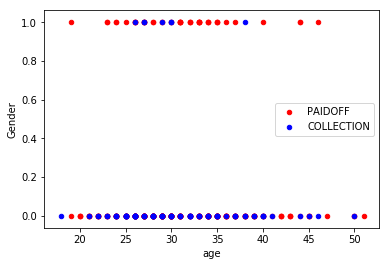

In [69]:
ax = df[df['loan_status'] == 2][0:350].plot(kind='scatter', x='age', y='Gender', color='Red', label='PAIDOFF');
df[df['loan_status'] == 4][0:350].plot(kind='scatter', x='age', y='Gender', color='Blue', label='COLLECTION', ax=ax);
plt.show()

## Data pre-processing and selection

Lets first look at columns data types:

In [70]:
df.dtypes

loan_status    int64
Principal      int64
terms          int64
age            int64
education      int64
Gender         int64
dtype: object

In [71]:
feature_df = df[['Principal', 'terms', 'age', 'education', 'Gender']]
x = np.asarray(feature_df)
x[0:5]

array([[1000,   30,   45,    3,    0],
       [1000,   30,   33,    4,    1],
       [1000,   15,   27,    5,    0],
       [1000,   30,   28,    5,    1],
       [1000,   30,   29,    5,    0]])

We want the model to predict the value of loan_status (that is, PAIDOFF (=2) or COLLECTION (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [72]:
df['loan_status'] = df['loan_status'].astype('int')
y = np.asarray(df['loan_status'])
y [0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset

Okay, we split our dataset into train and test set:

In [73]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [74]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train) 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

After being fitted, the model can then be used to predict new values:

In [75]:
yhat = clf.predict(x_test)
yhat [0:5]

array([2, 2, 2, 4, 2])

<h2 id="evaluation">Evaluation</h2>

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [77]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       0.78      0.96      0.86        55
           4       0.00      0.00      0.00        15

   micro avg       0.76      0.76      0.76        70
   macro avg       0.39      0.48      0.43        70
weighted avg       0.61      0.76      0.68        70

Confusion matrix, without normalization
[[53  2]
 [15  0]]


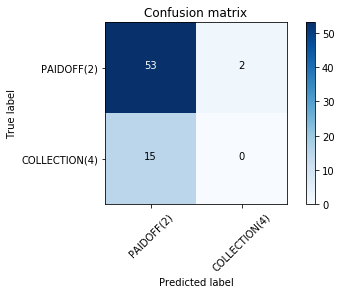

In [78]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(2)','COLLECTION(4)'],normalize= False,  title='Confusion matrix')

We can also easily use the __f1_score__ from sklearn library:

In [79]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.6771196283391405

_For jaccard index for accuracy:_

In [80]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7571428571428571

# Logistic Regression

In [81]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [82]:
df.head()

,loan_status,Principal,terms,age,education,Gender
0,2,1000,30,45,3,0
1,2,1000,30,33,4,1
2,2,1000,15,27,5,0
3,2,1000,30,28,5,1
4,2,1000,30,29,5,0


In [83]:
feature_df = df[['Principal', 'terms', 'age', 'education', 'Gender']]
x = np.asarray(feature_df)
x[0:5]

array([[1000,   30,   45,    3,    0],
       [1000,   30,   33,    4,    1],
       [1000,   15,   27,    5,    0],
       [1000,   30,   28,    5,    1],
       [1000,   30,   29,    5,    0]])

In [84]:
y = np.asarray(df['loan_status'])
y [0:5]

array([2, 2, 2, 2, 2])

Also, we normalize the dataset:

In [85]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.52,  0.92,  2.33, -1.07, -0.42],
       [ 0.52,  0.92,  0.34, -0.01,  2.38],
       [ 0.52, -0.96, -0.65,  1.05, -0.42],
       [ 0.52,  0.92, -0.49,  1.05,  2.38],
       [ 0.52,  0.92, -0.32,  1.05, -0.42]])

## Train/Test dataset

Okay, we split our dataset into train and test set:

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


<h2 id="modeling">Modeling (Logistic Regression with Scikit-learn)</h2>

Lets build our model using __LogisticRegression__ from Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. You can find extensive information about the pros and cons of these optimizers if you search it in internet.

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem in machine learning models.
__C__ parameter indicates __inverse of regularization strength__ which must be a positive float. Smaller values specify stronger regularization. 
Now lets fit our model with train set:

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Now we can predict using our test set:

In [88]:
yhat = LR.predict(X_test)
yhat

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

__predict_proba__  returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X):

In [89]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.57, 0.43],
       [0.62, 0.38],
       [0.6 , 0.4 ],
       [0.55, 0.45],
       [0.58, 0.42],
       [0.59, 0.41],
       [0.58, 0.42],
       [0.59, 0.41],
       [0.55, 0.45],
       [0.58, 0.42],
       [0.56, 0.44],
       [0.57, 0.43],
       [0.68, 0.32],
       [0.56, 0.44],
       [0.63, 0.37],
       [0.66, 0.34],
       [0.55, 0.45],
       [0.6 , 0.4 ],
       [0.56, 0.44],
       [0.58, 0.42],
       [0.63, 0.37],
       [0.57, 0.43],
       [0.56, 0.44],
       [0.61, 0.39],
       [0.67, 0.33],
       [0.56, 0.44],
       [0.56, 0.44],
       [0.7 , 0.3 ],
       [0.56, 0.44],
       [0.67, 0.33],
       [0.6 , 0.4 ],
       [0.61, 0.39],
       [0.61, 0.39],
       [0.58, 0.42],
       [0.68, 0.32],
       [0.61, 0.39],
       [0.56, 0.44],
       [0.62, 0.38],
       [0.62, 0.38],
       [0.6 , 0.4 ],
       [0.56, 0.44],
       [0.58, 0.42],
       [0.62, 0.38],
       [0.56, 0.44],
       [0.6 , 0.4 ],
       [0.56, 0.44],
       [0.6 , 0.4 ],
       [0.57,

<h2 id="evaluation">Evaluation</h2>

### jaccard index
Lets try jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection divided by the size of the union of two label sets. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.


In [90]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7857142857142857

__F1 score:__
Now we are in the position to calculate the F1 scores for each label based on the precision.

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.


And finally, we can tell the average accuracy for this classifier is the average of the F1-score for both labels, which is 0.69 in our case.

In [91]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6914285714285714

### log loss
Now, lets try __log loss__ for evaluation. In logistic regression, the output can be the probability of customer churn is yes (or equals to 1). This probability is a value between 0 and 1.
Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1. 

In [92]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.6005889539164448

# Report
We should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.44    | 0.43     | NA      |
| Decision Tree      | 0.73    | 0.62     | NA      |
| SVM                | 0.76    | 0.68     | NA      |
| LogisticRegression | 0.44    | 0.69     | 0.60    |